In [1]:
from IPython import display
from bs4 import BeautifulSoup as bs
import requests
import json
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:.1f}'.format

from sklearn.preprocessing import OneHotEncoder


# Introduction

According to the CDC, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

# Obtain

This project requires data pulled from two different sources, the City of New York and Yelp. To obtain the data we will call the API keys.

## NYC Open Data Portal

In [2]:
doh = pd.read_csv('data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
doh

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.765040,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.0,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.886691,-73.907056,208.0,11.0,29500.0,2084186.0,2.057960e+09,BX29
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.0,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.762786,-73.971486,105.0,4.0,11202.0,1036073.0,1.012930e+09,MN17
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.0,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.762786,-73.971486,105.0,4.0,11202.0,1036073.0,1.012930e+09,MN17
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.0,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.736185,-73.858052,404.0,21.0,43702.0,4047915.0,4.019480e+09,QN25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,NaN,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000e+00,NaN
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.0,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premise...,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.764364,-73.981362,105.0,4.0,13700.0,1024857.0,1.010260e+09,MN17
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.0,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.757244,-73.983815,105.0,4.0,11900.0,1089796.0,1.009980e+09,MN17
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.0,7184508363,Spanish,07/20/2018,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizing solution.,Critical,12,A,07/20/2018,03/24/2022,Cycle Inspection / Initial Inspection,40.826352,-73.876066,209.0,18.0,5001.0,2023533.0,2.037160e+09,BX55


In [3]:
doh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186227 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  186227 non-null  int64  
 1   DBA                    186200 non-null  object 
 2   BORO                   186227 non-null  object 
 3   BUILDING               185799 non-null  object 
 4   STREET                 186227 non-null  object 
 5   ZIPCODE                183146 non-null  float64
 6   PHONE                  186214 non-null  object 
 7   CUISINE DESCRIPTION    186226 non-null  object 
 8   INSPECTION DATE        186227 non-null  object 
 9   ACTION                 186227 non-null  object 
 10  VIOLATION CODE         185413 non-null  object 
 11  VIOLATION DESCRIPTION  185863 non-null  object 
 12  CRITICAL FLAG          186227 non-null  object 
 13  SCORE                  186227 non-null  int64  
 14  GRADE                  67933 non-nul

In [4]:
doh.dropna(subset=['PHONE'],inplace=True)

In [5]:
doh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186214 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  186214 non-null  int64  
 1   DBA                    186187 non-null  object 
 2   BORO                   186214 non-null  object 
 3   BUILDING               185786 non-null  object 
 4   STREET                 186214 non-null  object 
 5   ZIPCODE                183133 non-null  float64
 6   PHONE                  186214 non-null  object 
 7   CUISINE DESCRIPTION    186213 non-null  object 
 8   INSPECTION DATE        186214 non-null  object 
 9   ACTION                 186214 non-null  object 
 10  VIOLATION CODE         185400 non-null  object 
 11  VIOLATION DESCRIPTION  185850 non-null  object 
 12  CRITICAL FLAG          186214 non-null  object 
 13  SCORE                  186214 non-null  int64  
 14  GRADE                  67924 non-nul

In [235]:
# How many unique restaurants are in this dataset?
doh['CAMIS'].nunique()

19790

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

"A" grade: 0 to 13 points for sanitary violations
"B" grade: 14 to 27 points for sanitary violations
"C" grade: 28 or more points for sanitary violations

In [7]:
doh['A'] = doh['SCORE'] < 14
doh['B'] = (doh['SCORE'] > 13) & (doh['SCORE'] < 28)
doh['C'] = doh['SCORE'] > 27

In [8]:
doh

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,A,B,C
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.0,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.765040,-73.987795,104.0,3.0,13300.0,1025235.0,1.010430e+09,MN15,False,True,False
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.0,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.886691,-73.907056,208.0,11.0,29500.0,2084186.0,2.057960e+09,BX29,False,True,False
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.0,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.762786,-73.971486,105.0,4.0,11202.0,1036073.0,1.012930e+09,MN17,True,False,False
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.0,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.762786,-73.971486,105.0,4.0,11202.0,1036073.0,1.012930e+09,MN17,True,False,False
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.0,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.736185,-73.858052,404.0,21.0,43702.0,4047915.0,4.019480e+09,QN25,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,NaN,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000e+00,NaN,True,False,False
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.0,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premise...,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.764364,-73.981362,105.0,4.0,13700.0,1024857.0,1.010260e+09,MN17,True,False,False
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.0,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.757244,-73.983815,105.0,4.0,11900.0,1089796.0,1.009980e+09,MN17,False,False,True
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.0,7184508363,Spanish,07/20/2018,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizing solution.,Critical,12,A,07/20/2018,03/24/2022,Cycle Inspection / Initial Inspection,40.826352,-73.876066,209.0,18.0,5001.0,2023533.0,2.037160e+09,BX55,True,False,False


In [9]:
doh['PHONE'] = '+1'+doh['PHONE']

Of the 19,792 unique restaurants, 12,221 did not pass the intitial inspections at least once.

In [10]:
doh_grades = doh.groupby(['CAMIS'])['PHONE','BORO','BUILDING','STREET','ZIPCODE',
                                    'PHONE','CUISINE DESCRIPTION',
                                    'Latitude','Longitude','Community Board',
                                    'Council District','Census Tract',
                                    'A', 'B','C'].sum()

In [11]:
doh_grades

,ZIPCODE,Latitude,Longitude,Community Board,Council District,Census Tract,A,B,C
CAMIS,,,,,,,,,
30075445,83696.0,326.785850,-590.847775,1688.0,104.0,201600.0,1,7,0
30112340,56125.0,203.313258,-369.810407,1545.0,200.0,163500.0,5,0,0
30191841,50095.0,203.836629,-369.921552,520.0,15.0,69500.0,5,0,0
40356018,44896.0,162.319681,-295.928361,1252.0,188.0,139200.0,4,0,0
40356483,101106.0,365.581004,-665.162905,2862.0,414.0,630000.0,5,4,0
...,...,...,...,...,...,...,...,...,...
50115169,10002.0,40.714841,-73.991700,103.0,1.0,1600.0,1,0,0
50116155,33699.0,122.051758,-221.752145,948.0,123.0,111900.0,3,0,0
50117350,50090.0,203.762660,-369.947575,525.0,15.0,54500.0,5,0,0


In [12]:
doh_grades[doh_grades['B'] > 0]

,ZIPCODE,Latitude,Longitude,Community Board,Council District,Census Tract,A,B,C
CAMIS,,,,,,,,,
30075445,83696.0,326.785850,-590.847775,1688.0,104.0,201600.0,1,7,0
40356483,101106.0,365.581004,-665.162905,2862.0,414.0,630000.0,5,4,0
40362264,70175.0,285.548344,-517.773967,749.0,42.0,126700.0,3,4,0
40362274,70084.0,285.080205,-517.982347,714.0,7.0,38507.0,1,6,0
40362715,230115.0,936.235858,-1702.198016,2323.0,23.0,16100.0,7,11,5
...,...,...,...,...,...,...,...,...,...
50111805,30042.0,122.195939,-222.011203,306.0,9.0,20100.0,0,3,0
50113198,40008.0,162.854183,-295.984590,412.0,4.0,3200.0,0,4,0
50113951,41820.0,163.249463,-295.613108,808.0,32.0,33200.0,0,4,0


Of the 19,792 unique restaurants, 9,978 failed an initial cycle inspection at least once.

In [13]:
doh_grades[doh_grades['C'] > 0]

,ZIPCODE,Latitude,Longitude,Community Board,Council District,Census Tract,A,B,C
CAMIS,,,,,,,,,
40360076,112180.0,406.433297,-739.781887,3120.0,390.0,496000.0,4,0,6
40362715,230115.0,936.235858,-1702.198016,2323.0,23.0,16100.0,7,11,5
40363630,200560.0,815.505622,-1479.131518,2160.0,100.0,280000.0,2,11,7
40364179,190475.0,775.226054,-1405.243039,2033.0,133.0,366700.0,3,5,11
40364362,120228.0,489.124894,-887.733038,1260.0,48.0,124800.0,3,3,6
...,...,...,...,...,...,...,...,...,...
50110216,79604.0,285.233461,-517.186091,2828.0,147.0,188307.0,0,0,7
50112974,70049.0,285.004311,-518.044896,707.0,7.0,14700.0,0,0,7
50113139,100926.0,365.433842,-665.981428,2799.0,423.0,259200.0,0,0,9


Of the 19,792 unique restaurants, 5,648 severly failed an initial cycle inspection at least once and are at risk of being closed by the DOHMH.

In [236]:
doh.duplicated().sum()

0

In [237]:
doh.drop_duplicates(inplace=True)

In [238]:
doh.shape

(174712, 29)

In [17]:
doh['SCORE'].isna().sum()

0

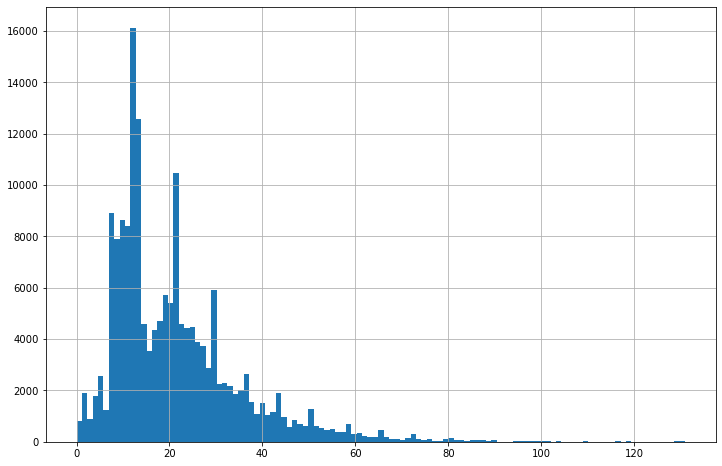

In [18]:
doh['SCORE'].hist(bins=113, figsize=(12,8));

In [19]:
doh['SCORE'].value_counts()

12     16132
13     12559
10      8627
11      8408
9       7904
       ...  
115        8
109        8
106        7
103        7
92         7
Name: SCORE, Length: 113, dtype: int64

In [20]:
doh['SCORE'].mean()

21.3592082970832

In [21]:
doh['SCORE'].median()

18.0

In [22]:
doh['SCORE'].mode()

0    12
dtype: int64

In [23]:
doh['GRADE'].isna().sum()

112800

In [24]:
doh['GRADE'].value_counts()

A    61251
N      650
C        6
Z        3
B        2
Name: GRADE, dtype: int64

In [25]:
doh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174712 entries, 0 to 186226
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  174712 non-null  int64  
 1   DBA                    174685 non-null  object 
 2   BORO                   174712 non-null  object 
 3   BUILDING               174307 non-null  object 
 4   STREET                 174712 non-null  object 
 5   ZIPCODE                171818 non-null  float64
 6   PHONE                  174712 non-null  object 
 7   CUISINE DESCRIPTION    174711 non-null  object 
 8   INSPECTION DATE        174712 non-null  object 
 9   ACTION                 174712 non-null  object 
 10  VIOLATION CODE         173916 non-null  object 
 11  VIOLATION DESCRIPTION  174348 non-null  object 
 12  CRITICAL FLAG          174712 non-null  object 
 13  SCORE                  174712 non-null  int64  
 14  GRADE                  61912 non-nul

In [26]:
doh['INSPECTION DATE'] =  pd.to_datetime(doh['INSPECTION DATE'])

In [ ]:
# doh.pivot(columns=['CAMIS','INSPECTION DATE'],values='SCORE')

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

Calling API

In [ ]:
# # Take a look at duplicated records
# duplicates = df1.duplicated(subset=['camis'], keep=False)
# df1.loc[duplicates.loc[duplicates==True].index].sort_values(by='camis')

## Yelp API

In [2]:
with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [29]:
creds.keys()

dict_keys(['api_key'])

In [10]:
#Business Search      
# url = 'https://api.yelp.com/v3/businesses/search'

#Business Match       
# url = 'https://api.yelp.com/v3/businesses/matches'

#Phone Search         
url = 'https://api.yelp.com/v3/businesses/search/phone'

#Business Details     
# url = 'https://api.yelp.com/v3/businesses/{id}'

#Business Reviews     
# url = 'https://api.yelp.com/v3/businesses/{id}/reviews'

In [ ]:
# #Business Search  
# headers = {
#     'Authorization': 'Bearer ' + creds['api_key']
#           }
# location = 'New York NY'
# SEARCH_LIMIT = 50

# url_params = {
#     'limit': SEARCH_LIMIT,
#     'location' : location.replace(' ','+'),
#     'offset': 0
#              }


# response = requests.get(url, headers=headers, params=url_params)
# print(response.status_code)

In [31]:
phone_numbers = set(doh['PHONE'])

In [32]:
len(phone_numbers)

18937

In [33]:
phone_numbers = list(phone_numbers)

In [155]:
phone_numbers1 = phone_numbers[1:1000]

In [199]:
phone_numbers2 = phone_numbers[1000:2000]

In [235]:
phone_numbers3 = phone_numbers[2000:2500]

In [236]:
phone_numbers4 = phone_numbers[2500:3500]

In [254]:
phone_numbers5 = phone_numbers[3500:5000]

In [298]:
phone_numbers6 = phone_numbers[5000:6000]

In [306]:
phone_numbers7 = phone_numbers[6000:7500]

In [317]:
phone_numbers8 = phone_numbers[7500:10000]

In [327]:
phone_numbers9 = phone_numbers[10000:12500]

In [34]:
phone_numbers10 = phone_numbers[12500:15000]

In [39]:
phone_numbers11 = phone_numbers[15000:17500]

In [67]:
phone_numbers12 = phone_numbers[17500:20000]

In [3]:
#Phone Search
def get_businesses(phone_numbers):
    
    biz_list = []
    
    for number in phone_numbers:
        url = 'https://api.yelp.com/v3/businesses/search/phone'
        headers = {'Authorization': 'Bearer ' + creds['api_key']}
        url_params = {'phone': number}
        response = requests.get(url, headers=headers, params=url_params)
        response_json = response.json()
        biz_list.extend(response_json.get('businesses','U'))
        
    while 'U' in biz_list:
        biz_list.remove('U')
        
    return biz_list

In [105]:
biz12_df = pd.DataFrame(biz_list)
biz12_df.to_csv('yelp_phone12.csv',index=False)
df = pd.read_csv('yelp_phone12.csv')
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,SGpqzs1ZtOqGPVTfedrf8w,simons-bbq-brooklyn-2,Simon's BBQ,https://s3-media0.fl.yelpcdn.com/bphoto/wBiZZY6KZlK0D80fHROhrA/o.jpg,False,https://www.yelp.com/biz/simons-bbq-brooklyn-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,32,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alias': 'chinese', 'title': 'Chinese'}]",4.0,"{'latitude': 40.6416092, 'longitude': -74.0027924}",[],$,"{'address1': '4823 8th Ave 1R', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11220', 'country': 'US', 'state': 'NY', 'display_address': ['4823 8th Ave 1R', 'Brooklyn, NY 11220']}",17184310688,(718) 431-0688
1,F-eRrDik2KK0sNjpGiNbAg,trattoria-il-gusto-wine-bar-new-york-2,Trattoria iL Gusto Wine Bar,https://s3-media0.fl.yelpcdn.com/bphoto/BSjc210htrdhV7R3LGYnHw/o.jpg,False,https://www.yelp.com/biz/trattoria-il-gusto-wine-bar-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,73,"[{'alias': 'wine_bars', 'title': 'Wine Bars'}, {'alias': 'italian', 'title': 'Italian'}, {'alias': 'desserts', 'title': 'Desserts'}]",3.5,"{'latitude': 40.78923, 'longitude': -73.9698499}","['delivery', 'pickup']",$$,"{'address1': '625 Columbus Ave', 'address2': '', 'address3': None, 'city': 'New York', 'zip_code': '10024', 'country': 'US', 'state': 'NY', 'display_address': ['625 Columbus Ave', 'New York, NY 10024']}",12125797970,(212) 579-7970
2,WVNKWxmjijbwvQrVHaPtQw,trattoria-pesce-pasta-quattro-new-york,Trattoria Pesce Pasta Quattro,https://s3-media0.fl.yelpcdn.com/bphoto/y_uAxhK6H_nxW_ny6ncXtg/o.jpg,True,https://www.yelp.com/biz/trattoria-pesce-pasta-quattro-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,42,"[{'alias': 'italian', 'title': 'Italian'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'wine_bars', 'title': 'Wine Bars'}]",3.5,"{'latitude': 40.78923, 'longitude': -73.9698499}","['delivery', 'pickup']",$$,"{'address1': '625 Columbus Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10024', 'country': 'US', 'state': 'NY', 'display_address': ['625 Columbus Ave', 'New York, NY 10024']}",12125797970,(212) 579-7970
3,edLi09LmjWXgL1NOCJ4qjA,bungalow-bar-rockaway-beach,Bungalow Bar,https://s3-media0.fl.yelpcdn.com/bphoto/e7zNdLKPXDzym15W6wU_iQ/o.jpg,False,https://www.yelp.com/biz/bungalow-bar-rockaway-beach?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,568,"[{'alias': 'tradamerican', 'title': 'American (Traditional)'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias': 'bars', 'title': 'Bars'}]",4.0,"{'latitude': 40.5890639, 'longitude': -73.817172}","['pickup', 'delivery']",$$,"{'address1': '377 Beach 92nd St', 'address2': '', 'address3': '', 'city': 'Rockaway Beach', 'zip_code': '11693', 'country': 'US', 'state': 'NY', 'display_address': ['377 Beach 92nd St', 'Rockaway Beach, NY 11693']}",17189452100,(718) 945-2100
4,hvMbN42EaHlZoHMS3degLg,sweet-talk-brooklyn,Sweet Talk,https://s3-media0.fl.yelpcdn.com/bphoto/6aXGfu845w3VNjEvQpYTUw/o.jpg,False,https://www.yelp.com/biz/sweet-talk-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,262,"[{'alias': 'cocktailbars', 'title': 'Cocktail Bars'}, {'alias': 'hawaiian', 'title': 'Hawaiian'}, {'alias': 'tacos', 'title': 'Tacos'}]",4.0,"{'latitude': 40.6712112426758, 'longitude': -73.9909439086914}","['delivery', 'pickup']",$$,"{'address1': '457 3rd Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11215', 'country': 'US', 'state': 'NY', 'display_address': ['457 3rd Ave', 'Brooklyn, NY 11215']}",17184993400,(718) 499-340

In [38]:
df_1 = pd.read_csv('yelp_phone1.csv')
df_2 = pd.read_csv('yelp_phone2.csv')
df_3 = pd.read_csv('yelp_phone3.csv')
df_4 = pd.read_csv('yelp_phone4.csv')
df_5 = pd.read_csv('yelp_phone5.csv')
df_6 = pd.read_csv('yelp_phone6.csv')
df_7 = pd.read_csv('yelp_phone7.csv')
df_8 = pd.read_csv('yelp_phone8.csv')
df_9 = pd.read_csv('yelp_phone9.csv')
df_10 = pd.read_csv('yelp_phone10.csv')
df_11 = pd.read_csv('yelp_phone11.csv')
df_12 = pd.read_csv('yelp_phone12.csv')

In [11]:
df_list = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [243]:
yelp_businesses_df = pd.concat(df_list,ignore_index=True)
yelp_businesses_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,fEsgUESZxOQtd4YEmAUuow,ii-caffe-latte-2-new-york-4,II Caffe Latte 2,https://s3-media0.fl.yelpcdn.com/bphoto/rL-1bjIrEvnG6zV8ofrZpg/o.jpg,False,https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,127,"[{'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'}, {'alias': 'desserts', 'title': 'Desserts'}, {'alias': 'cafes', 'title': 'Cafes'}]",3.5,"{'latitude': 40.8246899, 'longitude': -73.94704}","['delivery', 'pickup']",$$,"{'address1': '458 W 145th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10031', 'country': 'US', 'state': 'NY', 'display_address': ['458 W 145th St', 'New York, NY 10031']}",12122340202,(212) 234-0202
1,zm_ngfMxyU6d85AaTIgI7Q,chloes-restaurant-and-lounge-brooklyn,Chloe's Restaurant & Lounge,https://s3-media0.fl.yelpcdn.com/bphoto/AFD_nPVpU1rhI7VMWvbltA/o.jpg,False,https://www.yelp.com/biz/chloes-restaurant-and-lounge-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,192,"[{'alias': 'haitian', 'title': 'Haitian'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'seafood', 'title': 'Seafood'}]",2.5,"{'latitude': 40.63755, 'longitude': -73.89731}","['delivery', 'pickup']",$$,"{'address1': '9413 Ave L', 'address2': None, 'address3': '', 'city': 'Brooklyn', 'zip_code': '11236', 'country': 'US', 'state': 'NY', 'display_address': ['9413 Ave L', 'Brooklyn, NY 11236']}",13477709051,(347) 770-9051
2,LbGAKVX3cwZj4fUC2XOLxg,jahns-jackson-heights,Jahn's,https://s3-media0.fl.yelpcdn.com/bphoto/9Oa1n8Dyo_n2N9YIhJxsgw/o.jpg,False,https://www.yelp.com/biz/jahns-jackson-heights?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,172,"[{'alias': 'diners', 'title': 'Diners'}]",3.5,"{'latitude': 40.74941, 'longitude': -73.88497}","['delivery', 'pickup']",$$,"{'address1': '81-04 37th Ave', 'address2': '', 'address3': '', 'city': 'Jackson Heights', 'zip_code': '11372', 'country': 'US', 'state': 'NY', 'display_address': ['81-04 37th Ave', 'Jackson Heights, NY 11372']}",17186510700,(718) 651-0700
3,i8ejDDR4COtukAAA1Ls5fw,soba-ya-new-york,Soba-ya,https://s3-media0.fl.yelpcdn.com/bphoto/LnjY25INn-aM1eAyiav8XA/o.jpg,False,https://www.yelp.com/biz/soba-ya-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1496,"[{'alias': 'japanese', 'title': 'Japanese'}, {'alias': 'noodles', 'title': 'Noodles'}]",4.0,"{'latitude': 40.72965, 'longitude': -73.9878899}","['delivery', 'pickup']",$$,"{'address1': '229 E 9th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10003', 'country': 'US', 'state': 'NY', 'display_address': ['229 E 9th St', 'New York, NY 10003']}",12125336966,(212) 533-6966
4,YV0VaJgV2zotzI7XNUaMCQ,mcdonalds-new-york-100,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/X710tzNcQt5xzpJMVIpZHw/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-100?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,85,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",2.5,"{'latitude': 40.71852, 'longitude': -74.00115}",['delivery'],$,"{'address1': '262 Canal St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10013', 'country': 'US', 'state': 'NY', 'display_address': ['262 Canal St', 'New York, NY 10013']}",12129415823,(212) 941-5823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,osnb51lPIHxUKRlcg7idwA,kathys-dumplings-brooklyn,Kathy's Dumplings,https://s3-media0.fl.yelpcdn.com/bphoto/4PHqX5uxT

In [108]:
yelp_businesses_df.to_csv('yelp_businesses.csv',index=False)
yelp_df = pd.read_csv('yelp_businesses.csv')
yelp_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,fEsgUESZxOQtd4YEmAUuow,ii-caffe-latte-2-new-york-4,II Caffe Latte 2,https://s3-media0.fl.yelpcdn.com/bphoto/rL-1bjIrEvnG6zV8ofrZpg/o.jpg,False,https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,127,"[{'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'}, {'alias': 'desserts', 'title': 'Desserts'}, {'alias': 'cafes', 'title': 'Cafes'}]",3.5,"{'latitude': 40.8246899, 'longitude': -73.94704}","['delivery', 'pickup']",$$,"{'address1': '458 W 145th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10031', 'country': 'US', 'state': 'NY', 'display_address': ['458 W 145th St', 'New York, NY 10031']}",12122340202,(212) 234-0202
1,zm_ngfMxyU6d85AaTIgI7Q,chloes-restaurant-and-lounge-brooklyn,Chloe's Restaurant & Lounge,https://s3-media0.fl.yelpcdn.com/bphoto/AFD_nPVpU1rhI7VMWvbltA/o.jpg,False,https://www.yelp.com/biz/chloes-restaurant-and-lounge-brooklyn?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,192,"[{'alias': 'haitian', 'title': 'Haitian'}, {'alias': 'salad', 'title': 'Salad'}, {'alias': 'seafood', 'title': 'Seafood'}]",2.5,"{'latitude': 40.63755, 'longitude': -73.89731}","['delivery', 'pickup']",$$,"{'address1': '9413 Ave L', 'address2': None, 'address3': '', 'city': 'Brooklyn', 'zip_code': '11236', 'country': 'US', 'state': 'NY', 'display_address': ['9413 Ave L', 'Brooklyn, NY 11236']}",13477709051,(347) 770-9051
2,LbGAKVX3cwZj4fUC2XOLxg,jahns-jackson-heights,Jahn's,https://s3-media0.fl.yelpcdn.com/bphoto/9Oa1n8Dyo_n2N9YIhJxsgw/o.jpg,False,https://www.yelp.com/biz/jahns-jackson-heights?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,172,"[{'alias': 'diners', 'title': 'Diners'}]",3.5,"{'latitude': 40.74941, 'longitude': -73.88497}","['delivery', 'pickup']",$$,"{'address1': '81-04 37th Ave', 'address2': '', 'address3': '', 'city': 'Jackson Heights', 'zip_code': '11372', 'country': 'US', 'state': 'NY', 'display_address': ['81-04 37th Ave', 'Jackson Heights, NY 11372']}",17186510700,(718) 651-0700
3,i8ejDDR4COtukAAA1Ls5fw,soba-ya-new-york,Soba-ya,https://s3-media0.fl.yelpcdn.com/bphoto/LnjY25INn-aM1eAyiav8XA/o.jpg,False,https://www.yelp.com/biz/soba-ya-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,1496,"[{'alias': 'japanese', 'title': 'Japanese'}, {'alias': 'noodles', 'title': 'Noodles'}]",4.0,"{'latitude': 40.72965, 'longitude': -73.9878899}","['delivery', 'pickup']",$$,"{'address1': '229 E 9th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10003', 'country': 'US', 'state': 'NY', 'display_address': ['229 E 9th St', 'New York, NY 10003']}",12125336966,(212) 533-6966
4,YV0VaJgV2zotzI7XNUaMCQ,mcdonalds-new-york-100,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/X710tzNcQt5xzpJMVIpZHw/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-100?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=82uXkAt1Tiw7u9_h33zr1A,85,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",2.5,"{'latitude': 40.71852, 'longitude': -74.00115}",['delivery'],$,"{'address1': '262 Canal St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': '10013', 'country': 'US', 'state': 'NY', 'display_address': ['262 Canal St', 'New York, NY 10013']}",12129415823,(212) 941-5823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,osnb51lPIHxUKRlcg7idwA,kathys-dumplings-brooklyn,Kathy's Dumplings,https://s3-media0.fl.yelpcdn.com/bphoto/4PHqX5uxT

In [109]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 1.9+ MB


In [234]:
yelp_df['display_phone'].nunique()

10294

In [231]:
yelp_df[yelp_df.duplicated(['id'], keep=False)]

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
6,yIWKtjt9v0m7i8mKBQlsug,la-casa-de-julia-woodside,La Casa de Julia,https://s3-media0.fl.yelpcdn.com/bphoto/OOY3KQW7ylz-tDRyNkdRtA/o.jpg,False,https://www.yelp.com/biz/la-casa-de-julia-woodside,9,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias': 'sportsbars', 'title': 'Sports Bars'}]",3.5,"{'latitude': 40.74618, 'longitude': -73.89954}","['delivery', 'pickup']",NaN,"{'address1': '64-09 Roosevelt Ave', 'address2': None, 'address3': None, 'city': 'Woodside', 'zip_code': '11377', 'country': 'US', 'state': 'NY', 'display_address': ['64-09 Roosevelt Ave', 'Woodside, NY 11377']}",13478080627,(347) 808-0627
9,zdgJUdnxkRmmtb4qIk0ZHg,sushi-zo-midtown-new-york-new-york,Sushi Zo | Midtown New York,https://s3-media0.fl.yelpcdn.com/bphoto/kibfipheDdcSR7MGtjmH5Q/o.jpg,False,https://www.yelp.com/biz/sushi-zo-midtown-new-york-new-york,28,"[{'alias': 'sushi', 'title': 'Sushi Bars'}]",4.5,"{'latitude': 40.74971, 'longitude': -73.97759}",[],$$$$,"{'address1': '127 E 39th St', 'address2': '', 'address3': None, 'city': 'New York', 'zip_code': '10016', 'country': 'US', 'state': 'NY', 'display_address': ['127 E 39th St', 'New York, NY 10016']}",19172658054,(917) 265-8054
10,v8npyOL2ADgobgr6pSUNuA,mcdonalds-brooklyn-100,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/Ujr37VSP0i5PitOv-uEMfQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-brooklyn-100,60,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",2.5,"{'latitude': 40.5993204166153, 'longitude': -73.9889772317838}",['delivery'],$,"{'address1': '2413 86th St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11214', 'country': 'US', 'state': 'NY', 'display_address': ['2413 86th St', 'Brooklyn, NY 11214']}",17183729098,(718) 372-9098
11,HhOu55Tw7IuUL3h65GF25A,bonjour-crepes-and-wine-new-york-2,Bonjour Crepes & Wine,https://s3-media0.fl.yelpcdn.com/bphoto/QRsfojUgceb7LVhTCLGwuw/o.jpg,False,https://www.yelp.com/biz/bonjour-crepes-and-wine-new-york-2,161,"[{'alias': 'creperies', 'title': 'Creperies'}, {'alias': 'wine_bars', 'title': 'Wine Bars'}, {'alias': 'coffee', 'title': 'Coffee & Tea'}]",3.5,"{'latitude': 40.78456, 'longitude': -73.95219}","['pickup', 'delivery']",$$,"{'address1': '1442 Lexington Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10128', 'country': 'US', 'state': 'NY', 'display_address': ['1442 Lexington Ave', 'New York, NY 10128']}",12125344300,(212) 534-4300
13,wLvcBF3tbvu5h6XDYfm7DA,burp-castle-new-york,Burp Castle,https://s3-media0.fl.yelpcdn.com/bphoto/3aqHNbGm3mRGIjclVq0CaA/o.jpg,False,https://www.yelp.com/biz/burp-castle-new-york,557,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'lounges', 'title': 'Lounges'}]",4.0,"{'latitude': 40.7283252192663, 'longitude': -73.9886448736218}",[],$$,"{'address1': '41 E 7th St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10003', 'country': 'US', 'state': 'NY', 'display_address': ['41 E 7th St', 'New York, NY 10003']}",12129824576,(212) 982-4576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,osnb51lPIHxUKRlcg7idwA,kathys-dumplings-brooklyn,Kathy's Dumplings,https://s3-media0.fl.yelpcdn.com/bphoto/4PHqX5uxThKNvLcD0DZqrw/o.jpg,False,https://www.yelp.com/biz/kathys-dumplings-brooklyn,231,"[{'alias': 'chinese', 'title': 'Chinese'}]",4.0,"{'latitude': 40.6279735, 'longitude': -74.0293625}","['pickup', 'delivery']",$,"{'address1': '7924 3rd Ave', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11209', 'country': 'US', 'state': 'NY', 'display_address': ['7924 3rd Ave', 'Brooklyn, NY 11209']}",17188337000,(718) 833-7000
17298,SkYcO8FaqYgoP-66g58OMw,thai-pot-forest-hills,Thai Pot,https://s3-media0.fl.yelpcdn.com/bphoto/Qu_oE3bTpWt-pJw8r4LXxw/o.jpg,False,https://www.yelp.com/biz/thai-pot-forest-hills,258,"[{'alias': 'thai', 'title': 'Thai

In [110]:
yelp_businesses_df.describe()

,review_count,rating,phone
count,17302.0,17302.0,17302.0
mean,189.5,3.5,15227799712.2
std,378.4,0.8,2494930771.0
min,1.0,1.0,12062250663.0
25%,17.0,3.0,12127498940.5
50%,67.0,3.5,17182416042.0
75%,209.0,4.0,17186241444.0
max,13458.0,5.0,19732238527.0


In [111]:
yelp_businesses_df['review_count'].sum()

3278066

In [12]:
for df in df_list:
    df['url'] = 'https://www.yelp.com/biz/'+df['alias']

In [13]:
df_10_2 = df_10.loc[1000:2173]
# df_10_2.to_csv('df_10_2',index=False)

In [39]:
url_list12 = list(df_12['url'])
len(url_list12)

2139

In [41]:
def get_text(url_list):
    review_txt = []

    for url in url_list:
        req = requests.get(url)
        soup = bs(req.content)
        comments = soup.find_all(class_='raw__09f24__T4Ezm', lang="en")
        comment_txt = []

        for comment in comments:
            comment_txt.append(comment.text)

        comment_corp = ('.'.join(comment_txt))
        review_txt.append(comment_corp)
    return review_txt

In [16]:
review_txt10_2 = get_text(url_list10_2)

In [25]:
review_txt11 = get_text(url_list11)

In [27]:
review_txt11_2 = get_text(url_list11)

In [42]:
review_txt12 = get_text(url_list12)

In [43]:
rvw_txt = pd.DataFrame(review_txt12,columns=['Review_Text'])
rvw_txt.to_csv('rvw_txt12.csv',index=False)


In [36]:
rvw_txt[rvw_txt['Review_Text']  == '']

,Review_Text
9,
11,
14,
15,
17,
...,...
2125,
2126,
2129,
2132,


In [13]:
df_2['Review_Text'] = review_txt2

In [18]:
rvw1 = pd.read_csv('rvw_txt1.csv')

In [23]:
df_1['Reviews'] =  rvw1

In [21]:
rvw10_2 = pd.read_csv('rvw_txt10_2.csv')

In [22]:
df_10_2['Reviews'] = rvw10_2
df_10_2

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,Reviews
1000,l4uvmfRL7xMFlcLo_FK4dw,pepe-rosso-to-go-new-york-2,Pepe Rosso To Go,NaN,True,https://www.yelp.com/biz/pepe-rosso-to-go-new-york-2,5,"[{'alias': 'italian', 'title': 'Italian'}, {'alias': 'seafood', 'title': 'Seafood'}]",4.0,"{'latitude': 40.763996, 'longitude': -73.986862}",[],NaN,"{'address1': '346 W 52nd St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10019', 'country': 'US', 'state': 'NY', 'display_address': ['346 W 52nd St', 'New York, NY 10019']}",12126774555,(212) 677-4555,NaN
1001,1pbM_bWgGfTbzR8ou5vb2w,dallas-bbq-brooklyn,Dallas BBQ,https://s3-media0.fl.yelpcdn.com/bphoto/DYXVQ9ix_TdNuxH0BGDj9g/o.jpg,False,https://www.yelp.com/biz/dallas-bbq-brooklyn,416,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alias': 'venues', 'title': 'Venues & Event Spaces'}]",3.0,"{'latitude': 40.690003956348185, 'longitude': -73.98709323203853}","['delivery', 'pickup']",$$,"{'address1': '180 Livingston St', 'address2': '', 'address3': '', 'city': 'Brooklyn', 'zip_code': '11201', 'country': 'US', 'state': 'NY', 'display_address': ['180 Livingston St', 'Brooklyn, NY 11201']}",17186435700,(718) 643-5700,NaN
1002,4Eziz-iTjfj_pgxTo-StrQ,bamboo-sushi-new-york-5,Bamboo Sushi,https://s3-media0.fl.yelpcdn.com/bphoto/SUGzmuvtR9pZ8V0Qlaqmsg/o.jpg,False,https://www.yelp.com/biz/bamboo-sushi-new-york-5,138,"[{'alias': 'japanese', 'title': 'Japanese'}, {'alias': 'sushi', 'title': 'Sushi Bars'}]",3.5,"{'latitude': 40.7656397370609, 'longitude': -73.9573489797623}","['delivery', 'pickup']",$$,"{'address1': '1280 1st Ave', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': '10065', 'country': 'US', 'state': 'NY', 'display_address': ['1280 1st Ave', 'New York, NY 10065']}",12123961919,(212) 396-1919,NaN
1003,hWjWMY5HtHg1SS7kNAdOHw,stumptown-coffee-roasters-brooklyn-3,Stumptown Coffee Roasters,https://s3-media0.fl.yelpcdn.com/bphoto/prNm8znCx1Q7Rdp2csi1og/o.jpg,False,https://www.yelp.com/biz/stumptown-coffee-roasters-brooklyn-3,59,"[{'alias': 'coffeeroasteries', 'title': 'Coffee Roasteries'}]",4.0,"{'latitude': 40.68888, 'longitude': -73.99214}",['delivery'],$$$,"{'address1': '212B Pacific St', 'address2': '', 'address3': None, 'city': 'Brooklyn', 'zip_code': '11201', 'country': 'US', 'state': 'NY', 'display_address': ['212B Pacific St', 'Brooklyn, NY 11201']}",13474166741,(347) 416-6741,NaN
1004,AhWaMg_vGkCkTZIxO_fL7Q,chef-king-bronx,Chef King,https://s3-media0.fl.yelpcdn.com/bphoto/c1iplXOX0J58dwBLw6Vi5w/o.jpg,False,https://www.yelp.com/biz/chef-king-bronx,5,"[{'alias': 'restaurants', 'title': 'Restaurants'}]",2.0,"{'latitude': 40.865715, 'longitude': -73.856628}","['pickup', 'delivery']",NaN,"{'address1': '1075 Allerton Ave', 'address2': '', 'address3': '', 'city': 'Bronx', 'zip_code': '10469', 'country': 'US', 'state': 'NY', 'display_address': ['1075 Allerton Ave', 'Bronx, NY 10469']}",17185191119,(718) 519-1119,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,l2AYFhojzCSiqeZ4YG5iyQ,subway-brooklyn-153,Subway,https://s3-media0.fl.yelpcdn.com/bphoto/4I8jRpOiSlJfv5h3fS1nhw/o.jpg,False,https://www.yelp.com/biz/subway-brooklyn-153,10,"[{'alias': 'sandwiches', 'title': 'Sandwiches'}]",3.0,"{'latitude': 40.7035375, 'longitude': -73.9183278057669}","['delivery', 'pickup']",$,"{'address1': '120 Wyckoff Ave', 'address2': None, 'address3': None, 'city': 'Brooklyn', 'zip_code': '11237', 'country': 'US', 'state': 'NY', 'display_address': ['120 Wyckoff Ave', 'Brooklyn, NY 11237']}",17188212995,(718) 821-2995,NaN
2167,nkT08Tewf6TLaysiuiF8Ow,pig-n-whistle-new-york-11,Pig n Whistle,https://s3-media0.fl.yelpcdn.com/bphoto/dFo62aYLufYcNtc5FRjW_A/o.jpg,False,https://www.yelp.com/biz/pig-n-whistle-new-york-11,210,"[{'alias': 'pubs', 'title': 'Pubs'}, {'alias': 'newamerican', 'title': 'American (New)'}, {'alias': 'sportsbars', 'title': 'Sports Bars'}]",3.5,"{'latitude': 40.75239

In [23]:
df_10_2['Reviews'].isna().sum()

1044

In [ ]:
# def prepare_data(data_list):
#     """
#     This function takes in a list of dictionaries and prepares it
#     for analysis
#     """
    
#     # Make a new list to hold results
#     results = []
    
#     for business_data in data_list:
    
#         # Make a new dictionary to hold prepared data for this business
#         prepared_data = {}
        
#         # Extract name, review_count, rating, and price key-value pairs
#         # from business_data and add to prepared_data
#         # If a key is not present in business_data, add it to prepared_data
#         # with an associated value of None
#         for key in ("name", "review_count", "rating", "price"):
#             prepared_data[key] = business_data.get(key, None)
    
#         # Parse and add latitude and longitude columns
#         coordinates = business_data["coordinates"]
#         prepared_data["latitude"] = coordinates["latitude"]
#         prepared_data["longitude"] = coordinates["longitude"]
        
#         # Add to list if all values are present
#         if all(prepared_data.values()):
#             results.append(prepared_data)
    
#     return results
    
# # Test out function
# prepared_businesses = prepare_data(businesses)
# prepared_businesses[:5]

In [ ]:
# lat = []
# long = []

# for _,business in yelp_df.iterrows():
#     lat.append(business['coordinates']['latitude'])
#     long.append(business['coordinates']['longitude'])

# yelp_df['lat'] = lat
# yelp_df['long'] = long

## Getting Yelp Reviews

In [74]:
yelp_ids = list(yelp_businesses_df['id'])

In [82]:
 yelp_ids1 = yelp_ids[0:2]

In [83]:
yelp_ids1

['fEsgUESZxOQtd4YEmAUuow', 'zm_ngfMxyU6d85AaTIgI7Q']

In [84]:
review_corp = []

for business in  yelp_ids1:
    yelp_id = business
    url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
    headers = {'Authorization': 'Bearer ' + creds['api_key']}
    response = requests.get(url, headers=headers)
    response_json = response.json()
    response_json
    
    for review in response_json.get('reviews'):
        review_corp.append(review['text'])
        
    dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}

    df_test = pd.DataFrame(dict_test)
    
df_test

,yelp_id,review_text
0,zm_ngfMxyU6d85AaTIgI7Q,"Met my bestie for a warm beverage yesterday and we ended up here at Caffe Latte. Immediately upon entering, the lady working there let us know that the..."
1,zm_ngfMxyU6d85AaTIgI7Q,Walked in to check out their menu. Person working there didn't acknowledge me. I guess the dishes were more important than my patronage. Place was empty so...
2,zm_ngfMxyU6d85AaTIgI7Q,"I've been to this location twice and each time the service , the food and the atmosphere has CHANGED MY LIFE. I had the black Ink ravioli and my long time..."
3,zm_ngfMxyU6d85AaTIgI7Q,- good griot\n- nice pairing with the waffle\n- not much traditional american breakfast\n- DJ turned up at 3:30 on a sunday\n- the champagne tasted cheap\n- the...
4,zm_ngfMxyU6d85AaTIgI7Q,"I ordered griot and rice on 3/1/22. When I reached home, I was disappointed with the amount of griot I received in a small tin container. I spent $20 plus..."
5,zm_ngfMxyU6d85AaTIgI7Q,"My business partner and I, attempted to have dinner at this establishment. The hostess greeted us and ask if we preferred to be seated at the front or the..."


In [118]:
review_corp

['Met my bestie for a warm beverage yesterday and we ended up here at Caffe Latte. Immediately upon entering, the lady working there let us know that the...',
 "Walked in to check out their menu. Person working there didn't acknowledge me. I guess the dishes were more important than my patronage. Place was empty so...",
 "I've been to this location twice and each time the service , the food and the atmosphere has CHANGED MY LIFE. I had the black Ink ravioli and my long time...",
 '- good griot\n- nice pairing with the waffle\n- not much traditional american breakfast\n- DJ turned up at 3:30 on a sunday\n- the champagne tasted cheap\n- the...',
 'I ordered  griot and rice on 3/1/22. When I reached home, I was disappointed with the amount of griot I received in a small tin container. I spent $20 plus...',
 'My business partner and I, attempted to have dinner at this establishment. The hostess greeted us and ask if we preferred to be seated at the front or the...']

In [119]:
for review in review_corp:
    print(len(review))

154
158
157
158
158
157


In [365]:
#Review Search 
yelp_id = 'fEsgUESZxOQtd4YEmAUuow'
url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
headers = {'Authorization': 'Bearer ' + creds['api_key']}
response = requests.get(url, headers=headers)
response_json = response.json()
response_json

{'reviews': [{'id': '3hXVb3qfwkpNYoVs3_9_QA',
   'url': 'https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&hrid=3hXVb3qfwkpNYoVs3_9_QA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=82uXkAt1Tiw7u9_h33zr1A',
   'text': 'Met my bestie for a warm beverage yesterday and we ended up here at Caffe Latte. Immediately upon entering, the lady working there let us know that the...',
   'rating': 5,
   'time_created': '2020-03-15 06:15:11',
   'user': {'id': 'KJd4Ey6_spwKIX0oq3CjQw',
    'profile_url': 'https://www.yelp.com/user_details?userid=KJd4Ey6_spwKIX0oq3CjQw',
    'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/DbTi7vDMa5PUndu-CdP54A/o.jpg',
    'name': 'Salisha T.'}},
  {'id': 'ONoRuoJtZXfo1rXs8GlGFA',
   'url': 'https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&hrid=ONoRuoJtZXfo1rXs8GlGFA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=82uXkAt1Tiw7u9_h3

In [382]:
review_corp = []

for review in response_json.get('reviews'):
    review_corp.append(review['text'])

In [366]:
yelp_id

'fEsgUESZxOQtd4YEmAUuow'

In [386]:
review_corp = ''.join(review_corp)

In [383]:
dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}
df_test = pd.DataFrame(dict_test)
df_test

,yelp_id,review_text
0,fEsgUESZxOQtd4YEmAUuow,Met my bestie for a warm beverage yesterday and we ended up here at Caffe Latte. Immediately upo...
1,fEsgUESZxOQtd4YEmAUuow,Walked in to check out their menu. Person working there didn't acknowledge me. I guess the dishe...
2,fEsgUESZxOQtd4YEmAUuow,"I've been to this location twice and each time the service , the food and the atmosphere has CHA..."


In [324]:
review_df = pd.DataFrame(response_json.get('reviews'))
review_df

,id,url,text,rating,time_created,user
0,3hXVb3qfwkpNYoVs3_9_QA,https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&hrid...,Met my bestie for a warm beverage yesterday and we ended up here at Caffe Latte. Immediately upo...,5,2020-03-15 06:15:11,"{'id': 'KJd4Ey6_spwKIX0oq3CjQw', 'profile_url': 'https://www.yelp.com/user_details?userid=KJd4Ey..."
1,ONoRuoJtZXfo1rXs8GlGFA,https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&hrid...,Walked in to check out their menu. Person working there didn't acknowledge me. I guess the dishe...,1,2021-10-24 14:53:53,"{'id': 'm-YCck86Jp7hzgswZDezgw', 'profile_url': 'https://www.yelp.com/user_details?userid=m-YCck..."
2,Y2kV33dCd9RBZ0WrrY6-DQ,https://www.yelp.com/biz/ii-caffe-latte-2-new-york-4?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&hrid...,"I've been to this location twice and each time the service , the food and the atmosphere has CHA...",5,2021-03-24 15:18:29,"{'id': 'zHGwvcogwOgDGzJsggjf0g', 'profile_url': 'https://www.yelp.com/user_details?userid=zHGwvc..."


# Data Understanding

For this project there will be two sources and types of data used:

* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* User generated Yelp business ratings and reviews

## Understanding NYC DOHMH Data

This dataset contains over 330,000 records, let's explore its contents.

In [ ]:
dohmh_df['inspection_date'] =  pd.to_datetime(dohmh_inspections['inspection_date'])

In [ ]:
dohmh_df['inspection_date'].min()

In [ ]:
dohmh_df['inspection_date'].max()

Inspections in this dataset range from May 2008 up to present day.

In [ ]:
# dohmh_df.set_index('inspection_date')

In [ ]:
dohmh_df['boro'].value_counts()

In [ ]:
dohmh_df['score'].value_counts()

In [ ]:
dohmh_df['score'].isna().sum()

In [ ]:
dohmh_df['grade'].value_counts()

In [ ]:
dohmh_df['grade'].value_counts(normalize=True)

In [ ]:
dohmh_df['grade'].isna().sum()

In [ ]:
dohmh_df['critical_flag'].value_counts()

Critical violations are those most likely to contribute to foodborne illness

In [ ]:
dohmh_df['critical_flag'].value_counts(normalize=True)

In [ ]:
dohmh_df['inspection_type'].value_counts()

In [ ]:
dohmh_inspections = dohmh_df[(dohmh_df['inspection_type'] ==
                              'Cycle Inspection / Initial Inspection') | (dohmh_df['inspection_type'] ==
                              'Cycle Inspection / Re-inspection')]

In [ ]:
dohmh_inspections['critical_flag'].value_counts()

In [ ]:
# Drop records with NA critical_flag

dohmh_ohe = dohmh_inspections[dohmh_inspections['critical_flag'] != 'Not Applicable']

In [ ]:
dohmh_ohe = pd.get_dummies(dohmh_inspections,columns=['critical_flag'])

In [ ]:
dohmh_ohe.head(2)

In [ ]:
critical_flags = dohmh_ohe.groupby(['camis'])['critical_flag_Critical'].count()

In [ ]:
critical_flags[critical_flagss]

In [ ]:
critical_flags['critical_flag_Not Critical'].sum()

In [ ]:
non_critical_flags = dohmh_ohe.groupby(['camis'])

In [ ]:
dohmh_inspections.duplicated().sum()

In [ ]:
dohmh_inspections.loc[dohmh_inspections.duplicated(keep='first'),:]

In [ ]:
dohmh_inspections.drop_duplicates().shape

In [ ]:
dohmh_inspections.duplicated(subset=['camis']).sum()

In [ ]:
dohmh_inspections['camis'].nunique()

There are approximately 28,000 restaurants that have been inspected by the DOHMH. Let's check out how many have ever been flagged for a critical violation.